# Run Ablations on Fjord

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# extract test data
df = pd.read_parquet('data/segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Local version of get labels
def get_hierarchical_labels(species_index, species_names, genus_names, class_names, binary_names, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    genus_index, class_index, binary_index = -1, -1, -1
    current_node = node
    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'genus':
            genus_index = genus_names.index(current_node.name) if current_node.name in genus_names else -1
        elif current_node.rank == 'class':
            class_index = class_names.index(current_node.name) if current_node.name in class_names else -1
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name) if current_node.name in binary_names else -1

    return genus_index, class_index, binary_index

## Plot logs

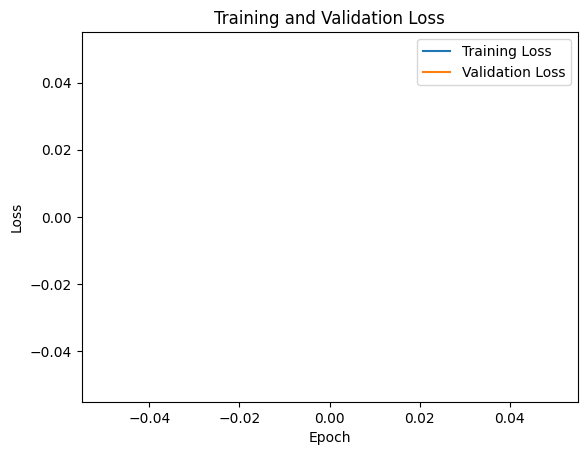

In [2]:
# Read the training log file
training_log = pd.read_csv('models/ablations/attention_removed/logs/model_alpha_0.00.csv')

# Plot the training and validation loss
plt.plot(training_log['Epoch'], training_log['Training Loss'], label='Training Loss')
plt.plot(training_log['Epoch'], training_log['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Load Model and run experiments

In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from collections import defaultdict
from anytree.importer import JsonImporter
from utils.custom_dataset import CustomDataset

def run_experiment(data_path, classes_file, model_path, ablation, root):
    df = pd.read_parquet(data_path)
    _, test_df = train_test_split(df, test_size=0.3, random_state=42)

    object_names = [line.strip() for line in open(classes_file, 'r')]
    subcategory_names, category_names, binary_names = [], [], []
    for node in root.descendants:
        if node.rank == 'genus':
            subcategory_names.append(node.name)
        elif node.rank == 'class':
            category_names.append(node.name)
        elif node.rank == 'binary':
            binary_names.append(node.name)

    rank_counts = defaultdict(int)
    for node in root.descendants:
        rank_counts[node.rank] += 1
    num_classes_hierarchy = [rank_counts['binary'], rank_counts['class'], rank_counts['genus'], rank_counts['species']]

  # Adjust model import and initialization based on ablation type
    if ablation == 'remove_features':
        from models.ablations.remove_features.hierarchical_cnn import HierarchicalCNN
        model = HierarchicalCNN(num_classes_hierarchy)
    elif ablation == 'attention_removed':
        from models.ablations.attention_removed.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    elif ablation == 'decreased_branch_complexity':
        from models.ablations.decreased_branch_complexity.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    elif ablation == 'increased_features_complexity':
        from models.ablations.increased_features_complexity.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    else:
        raise ValueError(f"Unsupported ablation study: {ablation}")


    model.load_state_dict(torch.load(model_path))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_dataset = CustomDataset(test_df, object_names, subcategory_names, category_names, binary_names, root)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    true_labels = {level: [] for level in ['binary', 'class', 'genus', 'species']}
    predictions = {level: [] for level in ['binary', 'class', 'genus', 'species']}

    with torch.no_grad():
        for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
            images, conf, iou, pred_species = [x.to(device) for x in [images, conf, iou, pred_species]]

            outputs = model(images, conf, iou, pred_species) if ablation != 'remove_features' else model(images)

            for i, output in enumerate(outputs):
                _, predicted = torch.max(output, 1)
                level = ['binary', 'class', 'genus', 'species'][i]
                predictions[level].extend(predicted.cpu().numpy())

            # Store true labels directly from the DataLoader
            true_labels['binary'].extend(binary_index.cpu().numpy())
            true_labels['class'].extend(class_index.cpu().numpy())
            true_labels['genus'].extend(genus_index.cpu().numpy())
            true_labels['species'].extend(species_index.cpu().numpy())

    f1_scores = {level: f1_score(true_labels[level], predictions[level], average='macro') for level in ['binary', 'class', 'genus', 'species']}
    return f1_scores

# Populate Taxonomy
importer = JsonImporter()
with open('/mnt/RAID/projects/FjordVision/data/ontology.json', 'r') as f:
    root = importer.read(f)

# Paths and setup
data_path = 'data/segmented-objects-dataset.parquet'
classes_file = '/mnt/RAID/datasets/The Fjord Dataset/fjord/classes.txt'
ablations = ['increased_features_complexity', 'remove_features', 'attention_removed', 'decreased_branch_complexity']
alpha_values = [0, 0.2, 0.5, 0.8, 1]

# Run experiments and collect results
results = []
for ablation in ablations:
    for alpha in alpha_values:
        model_path = f'models/ablations/{ablation}/weights/best_model_alpha_{alpha:.2f}.pth'
        f1_scores = run_experiment(data_path, classes_file, model_path, ablation, root)
        results.append({'Ablation': ablation, 'Alpha': alpha, **f1_scores})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [4]:
results_df.round(4)

,Ablation,Alpha,binary,class,genus,species
0,increased_features_complexity,0.0,0.6620,0.8822,0.9160,0.9220
1,increased_features_complexity,0.2,0.6622,0.8821,0.9161,0.9223
2,increased_features_complexity,0.5,0.6611,0.8824,0.9166,0.9218
3,increased_features_complexity,0.8,0.6621,0.8822,0.9163,0.9221
4,increased_features_complexity,1.0,0.6610,0.8819,0.9168,0.9223
5,remove_features,0.0,0.6571,0.8739,0.9055,0.9119
6,remove_features,0.2,0.6576,0.8754,0.9085,0.9136
7,remove_features,0.5,0.6572,0.8743,0.9069,0.9128
8,remove_features,0.8,0.6582,0.8753,0.9081,0.9142
9,remove_features,1.0,0.6588,0.8769,0.9097,0.9152


# Run Ablations on COCO

## Imports

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from anytree.importer import JsonImporter
from collections import defaultdict
from utils.custom_dataset import CustomDatasetCoco

def run_coco_experiment(data_path, classes_file, model_path, ablation, root_coco):
    df = pd.read_parquet(data_path)
    _, test_df = train_test_split(df, test_size=0.3, random_state=42)

    object_names = [line.strip() for line in open(classes_file, 'r')]
    subcategory_names, category_names, binary_names = [], [], []
    for node in root_coco.descendants:
        if node.rank == 'subcategory':
            subcategory_names.append(node.name)
        elif node.rank == 'category':
            category_names.append(node.name)
        elif node.rank == 'binary':
            binary_names.append(node.name)

    rank_counts = defaultdict(int)
    for node in root_coco.descendants:
        rank_counts[node.rank] += 1
    num_classes_hierarchy = [rank_counts['binary'], rank_counts['category'], rank_counts['subcategory'], rank_counts['object']]

  # Adjust model import and initialization based on ablation type
    if ablation == 'remove_features':
        from models.ablations.remove_features.hierarchical_cnn import HierarchicalCNN
        model = HierarchicalCNN(num_classes_hierarchy)
    elif ablation == 'attention_removed':
        from models.ablations.attention_removed.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    elif ablation == 'decreased_branch_complexity':
        from models.ablations.decreased_branch_complexity.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    elif ablation == 'increased_features_complexity':
        from models.ablations.increased_features_complexity.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
    else:
        raise ValueError(f"Unsupported ablation study: {ablation}")

    model.load_state_dict(torch.load(model_path))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_dataset = CustomDatasetCoco(test_df, object_names, subcategory_names, category_names, binary_names, root_coco)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    true_labels = {level: [] for level in ['binary', 'category', 'subcategory', 'object']}
    predictions = {level: [] for level in ['binary', 'category', 'subcategory', 'object']}

    with torch.no_grad():
        for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
            images, conf, iou, pred_species = [x.to(device) for x in [images, conf, iou, pred_species]]

            outputs = model(images, conf, iou, pred_species) if ablation != 'remove_features' else model(images)

            for i, output in enumerate(outputs):
                _, predicted = torch.max(output, 1)
                level = ['binary', 'category', 'subcategory', 'object'][i]
                predictions[level].extend(predicted.cpu().numpy())

            # Store true labels directly from the DataLoader
            true_labels['binary'].extend(binary_index.cpu().numpy())
            true_labels['category'].extend(class_index.cpu().numpy())
            true_labels['subcategory'].extend(genus_index.cpu().numpy())
            true_labels['object'].extend(species_index.cpu().numpy())

    f1_scores = {level: f1_score(true_labels[level], predictions[level], average='macro') for level in ['binary', 'category', 'subcategory', 'object']}
    return f1_scores

# Populate Taxonomy for COCO
importer = JsonImporter()
root_coco = importer.read(open('data/coco.json', 'r'))

# Paths and setup for COCO
data_path = 'data/coco-segmented-objects-dataset.parquet'
classes_file = '/mnt/RAID/datasets/coco/classes.txt'
ablations = ['increased_features_complexity', 'remove_features', 'attention_removed', 'decreased_branch_complexity']
alpha_values = [0, 0.2, 0.5, 0.8, 1]

# Run experiments and collect results for COCO
coco_results = []
for ablation in ablations:
    for alpha in alpha_values:
        model_path = f'models/ablations/{ablation}/weights-coco/best_model_alpha_{alpha:.2f}.pth'
        f1_scores = run_coco_experiment(data_path, classes_file, model_path, ablation, root_coco)
        coco_results.append({'Ablation': ablation, 'Alpha': alpha, **f1_scores})

# Convert results to DataFrame
coco_results_df = pd.DataFrame(coco_results)

In [6]:
coco_results_df.round(4)

,Ablation,Alpha,binary,category,subcategory,object
0,increased_features_complexity,0.0,0.6158,0.0502,0.0273,0.0778
1,increased_features_complexity,0.2,0.6269,0.0909,0.0050,0.5368
2,increased_features_complexity,0.5,0.6273,0.0644,0.0978,0.5821
3,increased_features_complexity,0.8,0.6272,0.0986,0.0483,0.5783
4,increased_features_complexity,1.0,0.6260,0.0886,0.0512,0.5115
5,remove_features,0.0,0.3508,0.2425,0.1225,0.0094
6,remove_features,0.2,0.3486,0.2943,0.1185,0.0094
7,remove_features,0.5,0.3103,0.2539,0.1177,0.0094
8,remove_features,0.8,0.3830,0.2742,0.1215,0.0093
9,remove_features,1.0,0.3607,0.2978,0.1170,0.0093
